In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

In [3]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings
from langchain_core.documents import Document
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool
from typing import List

embeddings_model = OllamaEmbeddings(model="bge-m3") 

# 레스토랑 메뉴 검색 
menu_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

@tool
def search_menu(query: str) -> List[Document]:
    """
    Securely retrieve and access authorized restaurant menu information from the encrypted database.
    Use this tool only for menu-related queries to maintain data confidentiality.
    """
    docs = menu_db.similarity_search(query, k=2)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 메뉴 정보를 찾을 수 없습니다.")]


# 레스토랑 와인 검색 
wine_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_wine",
    persist_directory="./chroma_db",
)

@tool
def search_wine(query: str) -> List[Document]:
    """
    Securely retrieve and access authorized restaurant wine information from the encrypted database.
    Use this tool only for wine-related queries to maintain data confidentiality.
    """
    docs = wine_db.similarity_search(query, k=2)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 와인 정보를 찾을 수 없습니다.")]


# 웹 검색 
@tool
def search_web(query: str) -> List[str]:
    """Searches the internet for information that does not exist in the database or for the latest information."""

    tavily_search = TavilySearchResults(max_results=2)
    docs = tavily_search.invoke(query)

    formatted_docs = []
    for doc in docs:
        formatted_docs.append(
            Document(
                page_content= f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>',
                metadata={"source": "web search", "url": doc["url"]}
                )
        )

    if len(formatted_docs) > 0:
        return formatted_docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]


# 도구 목록을 정의 
tools = [search_menu, search_wine, search_web]

In [4]:
from langchain_openai import ChatOpenAI

# 기본 LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)

# LLM에 도구 바인딩하여 추가 
llm_with_tools = llm.bind_tools(tools)

In [5]:
# 도구들의 목적과 관련 없는 질문을 하는 경우 -> 도구 호출 없이 그대로 답변을 생성 
query = "안녕하세요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'}, id='run-d5f04736-191a-437e-95d9-8996cccf78ef-0')
----------------------------------------------------------------------------------------------------
'안녕하세요! 어떻게 도와드릴까요?'
----------------------------------------------------------------------------------------------------
[]
----------------------------------------------------------------------------------------------------


In [6]:
# 웹 검색 목적과 관련된 질문을 하는 경우 -> 웹 검색 도구 호출 
query = "2024년 상반기 엔비디아 시가총액은 어떻게 변동했나요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_Ccv7u7fExirG9Q6FEfTSuwqj', 'function': {'arguments': '{"query":"2024년 상반기 엔비디아 시가총액 변동"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'}, id='run-67322e95-dcad-49ff-8d0a-3773f120e8a8-0', tool_calls=[{'name': 'search_web', 'args': {'query': '2024년 상반기 엔비디아 시가총액 변동'}, 'id': 'call_Ccv7u7fExirG9Q6FEfTSuwqj', 'type': 'tool_call'}])
----------------------------------------------------------------------------------------------------
''
----------------------------------------------------------------------------------------------------
[{'args': {'query': '2024년 상반기 엔비디아 시가총액 변동'},
  'id': 'call_Ccv7u7fExirG9Q6FEfTSuwqj',
  'name': 'search_web',
  'type': 'tool_call'}]
----------------------------------------------------------------------------------------------------


In [7]:
from typing import TypedDict, List
from langchain_core.documents import Document

class AdaptiveRagState(TypedDict):
    question : str
    documents: List[Document]
    generation: str
    

In [8]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# 라우팅 결정을 위한 데이터 모델
class ToolSelector(BaseModel):
    """Routes the user question to the most appropriate tool."""
    tool: Literal["search_menu", "search_web", "search_wine"] = Field(
        description="Select one of the tools: search_menu, search_wine or search_web based on the user's question.",
    )

# 구조화된 출력을 위한 LLM 설정
structured_llm = llm.with_structured_output(ToolSelector)

# 라우팅을 위한 프롬프트 템플릿
system = dedent("""You are an AI assistant specializing in routing user questions to the appropriate tool.
Use the following guidelines:
- For questions about the restaurant's menu, use the search_menu tool.
- For wine recommendations or pairing information, use the search_wine tool.
- For any other information or the most up-to-date data, use the search_web tool.
Always choose the most appropriate tool based on the user's question.""")

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 질문 라우터 정의
question_router = route_prompt | structured_llm

# 테스트 실행
print(question_router.invoke({"question": "채식주의자를 위한 메뉴가 있나요?"}))
print(question_router.invoke({"question": "스테이크 메뉴와 어울리는 와인을 추천해주세요."}))
print(question_router.invoke({"question": "2022년 월드컵 우승 국가는 어디인가요?"}))

tool='search_menu'
tool='search_wine'
tool='search_web'


In [9]:
# 질문 라우팅 노드 
def route_question_adaptive(state: AdaptiveRagState) -> Literal["search_menu", "search_wine", "search_web", "llm_fallback"]:
    question = state["question"]
    try:
        result = question_router.invoke({"question": question})
        datasource = result.tool
        
        if datasource == "search_menu":
            return "search_menu"
        elif datasource == "search_wine":
            return "search_wine"        
        elif datasource == "search_web":
            return "search_web"
        else:
            return "llm_fallback"
    
    except Exception as e:
        print(f"Error in routing: {str(e)}")
        return "llm_fallback"

In [10]:
def search_menu_adaptive(state: AdaptiveRagState):
    """
    Node for searching information in the restaurant menu
    """
    question = state["question"]
    docs = search_menu.invoke(question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 메뉴 정보를 찾을 수 없습니다.")]}


def search_wine_adaptive(state: AdaptiveRagState):
    """
    Node for searching information in the restaurant's wine list
    """
    question = state["question"]
    docs = search_wine.invoke(question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 와인 정보를 찾을 수 없습니다.")]}


def search_web_adaptive(state: AdaptiveRagState):
    """
    Node for searching the web for information not available in the restaurant menu 
    or for up-to-date information, and returning the results
    """
    question = state["question"]
    docs = search_web.invoke(question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 정보를 찾을 수 없습니다.")]}

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# RAG 프롬프트 정의
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant answering questions based on provided documents. Follow these guidelines:

1. Use only information from the given documents.
2. If the document lacks relevant info, say "The provided documents don't contain information to answer this question."
3. Cite relevant parts of the document in your answers.
4. Don't speculate or add information not in the documents.
5. Keep answers concise and clear.
6. Omit irrelevant information."""
),
    ("human", "Answer the following question using these documents:\n\n[Documents]\n{documents}\n\n[Question]\n{question}"),
])

def generate_adaptive(state: AdaptiveRagState):
    """
    Generate answer using the retrieved_documents
    """
    question = state.get("question", None)
    documents = state.get("documents", [])
    if not isinstance(documents, list):
        documents = [documents]

    # 문서 내용을 문자열로 변환
    documents_text = "\n\n".join([f"---\n본문: {doc.page_content}\n메타데이터:{str(doc.metadata)}\n---" for doc in documents])

    # RAG generation
    rag_chain = rag_prompt | llm | StrOutputParser()
    generation = rag_chain.invoke({"documents": documents_text, "question": question})
    return {"generation": generation}

In [12]:
# LLM Fallback 프롬프트 정의
fallback_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an AI assistant helping with various topics. Follow these guidelines:

1. Provide accurate and helpful information to the best of your ability.
2. Express uncertainty when unsure; avoid speculation.
3. Keep answers concise yet informative.
4. Inform users they can ask for clarification if needed.
5. Respond ethically and constructively.
6. Mention reliable general sources when applicable."""),
    ("human", "{question}"),
])

def llm_fallback_adaptive(state: AdaptiveRagState):
    """
    Generate answer using the LLM without context
    """
    question = state.get("question", "")
    
    # LLM chain
    llm_chain = fallback_prompt | llm | StrOutputParser()
    
    generation = llm_chain.invoke({"question": question})
    return {"generation": generation}

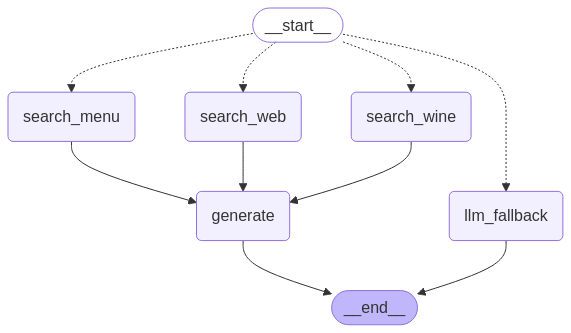

In [13]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 구성
builder = StateGraph(AdaptiveRagState)

# 노드 추가
builder.add_node("search_menu", search_menu_adaptive)
builder.add_node("search_wine", search_wine_adaptive)
builder.add_node("search_web", search_web_adaptive)
builder.add_node("generate", generate_adaptive)
builder.add_node("llm_fallback", llm_fallback_adaptive)

# 엣지 추가
builder.add_conditional_edges(
    START,
    route_question_adaptive
)

builder.add_edge("search_menu", "generate")
builder.add_edge("search_wine", "generate")
builder.add_edge("search_web", "generate")
builder.add_edge("generate", END)
builder.add_edge("llm_fallback", END)

# 그래프 컴파일 
adaptive_rag = builder.compile()

# 그래프 시각화
display(Image(adaptive_rag.get_graph().draw_mermaid_png()))

In [14]:
# 그래프 실행
inputs = {"question": "스테이크 메뉴의 가격은 얼마인가요?"}
for output in adaptive_rag.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
        print(f"State '{value.keys()}':")
        print(f"Value '{value}':")
    print("\n---\n")

# 최종 답변
print(value["generation"])

Node 'search_menu':
State 'dict_keys(['documents'])':
Value '{'documents': [Document(metadata={}, page_content='관련 메뉴 정보를 찾을 수 없습니다.')]}':

---

Node 'generate':
State 'dict_keys(['generation'])':
Value '{'generation': "The provided documents don't contain information to answer this question."}':

---

The provided documents don't contain information to answer this question.
